# Etude du prix de l'immobilier en Californie

# Importation des librairies

In [1]:
#base
import numpy as np
import pandas as pd

#data
from sklearn import datasets

#viz
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#preprocessing
from sklearn.model_selection import *
from sklearn.preprocessing import *

#modelisation
from lazypredict.Supervised import LazyRegressor
from lightgbm import LGBMRegressor

#evaluation
from sklearn.metrics import *

# Importation des données

Affichage du dataset

In [3]:
data = datasets.fetch_california_housing()
print(dir(data))

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']


In [4]:
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [5]:
dataset, dataset["Price"] = pd.DataFrame(columns=data["feature_names"], data=data.data), data.target 
dataset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.33,41.00,6.98,1.02,322.00,2.56,37.88,-122.23,4.53
1,8.30,21.00,6.24,0.97,2401.00,2.11,37.86,-122.22,3.58
2,7.26,52.00,8.29,1.07,496.00,2.80,37.85,-122.24,3.52
3,5.64,52.00,5.82,1.07,558.00,2.55,37.85,-122.25,3.41
4,3.85,52.00,6.28,1.08,565.00,2.18,37.85,-122.25,3.42


# Exploration des données

In [6]:
dataset.describe()     #sert à afficher un maximum de stats d'un seul coup.

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57,2.07
std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00,1.15
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80,1.20
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49,1.80
75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01,2.65
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,5.00


In [8]:
dataset.dtypes #vérification du type de données
#Toutes les données sont numériques, il n'y a donc pas de transformation à effectuer.

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
Price         float64
dtype: object

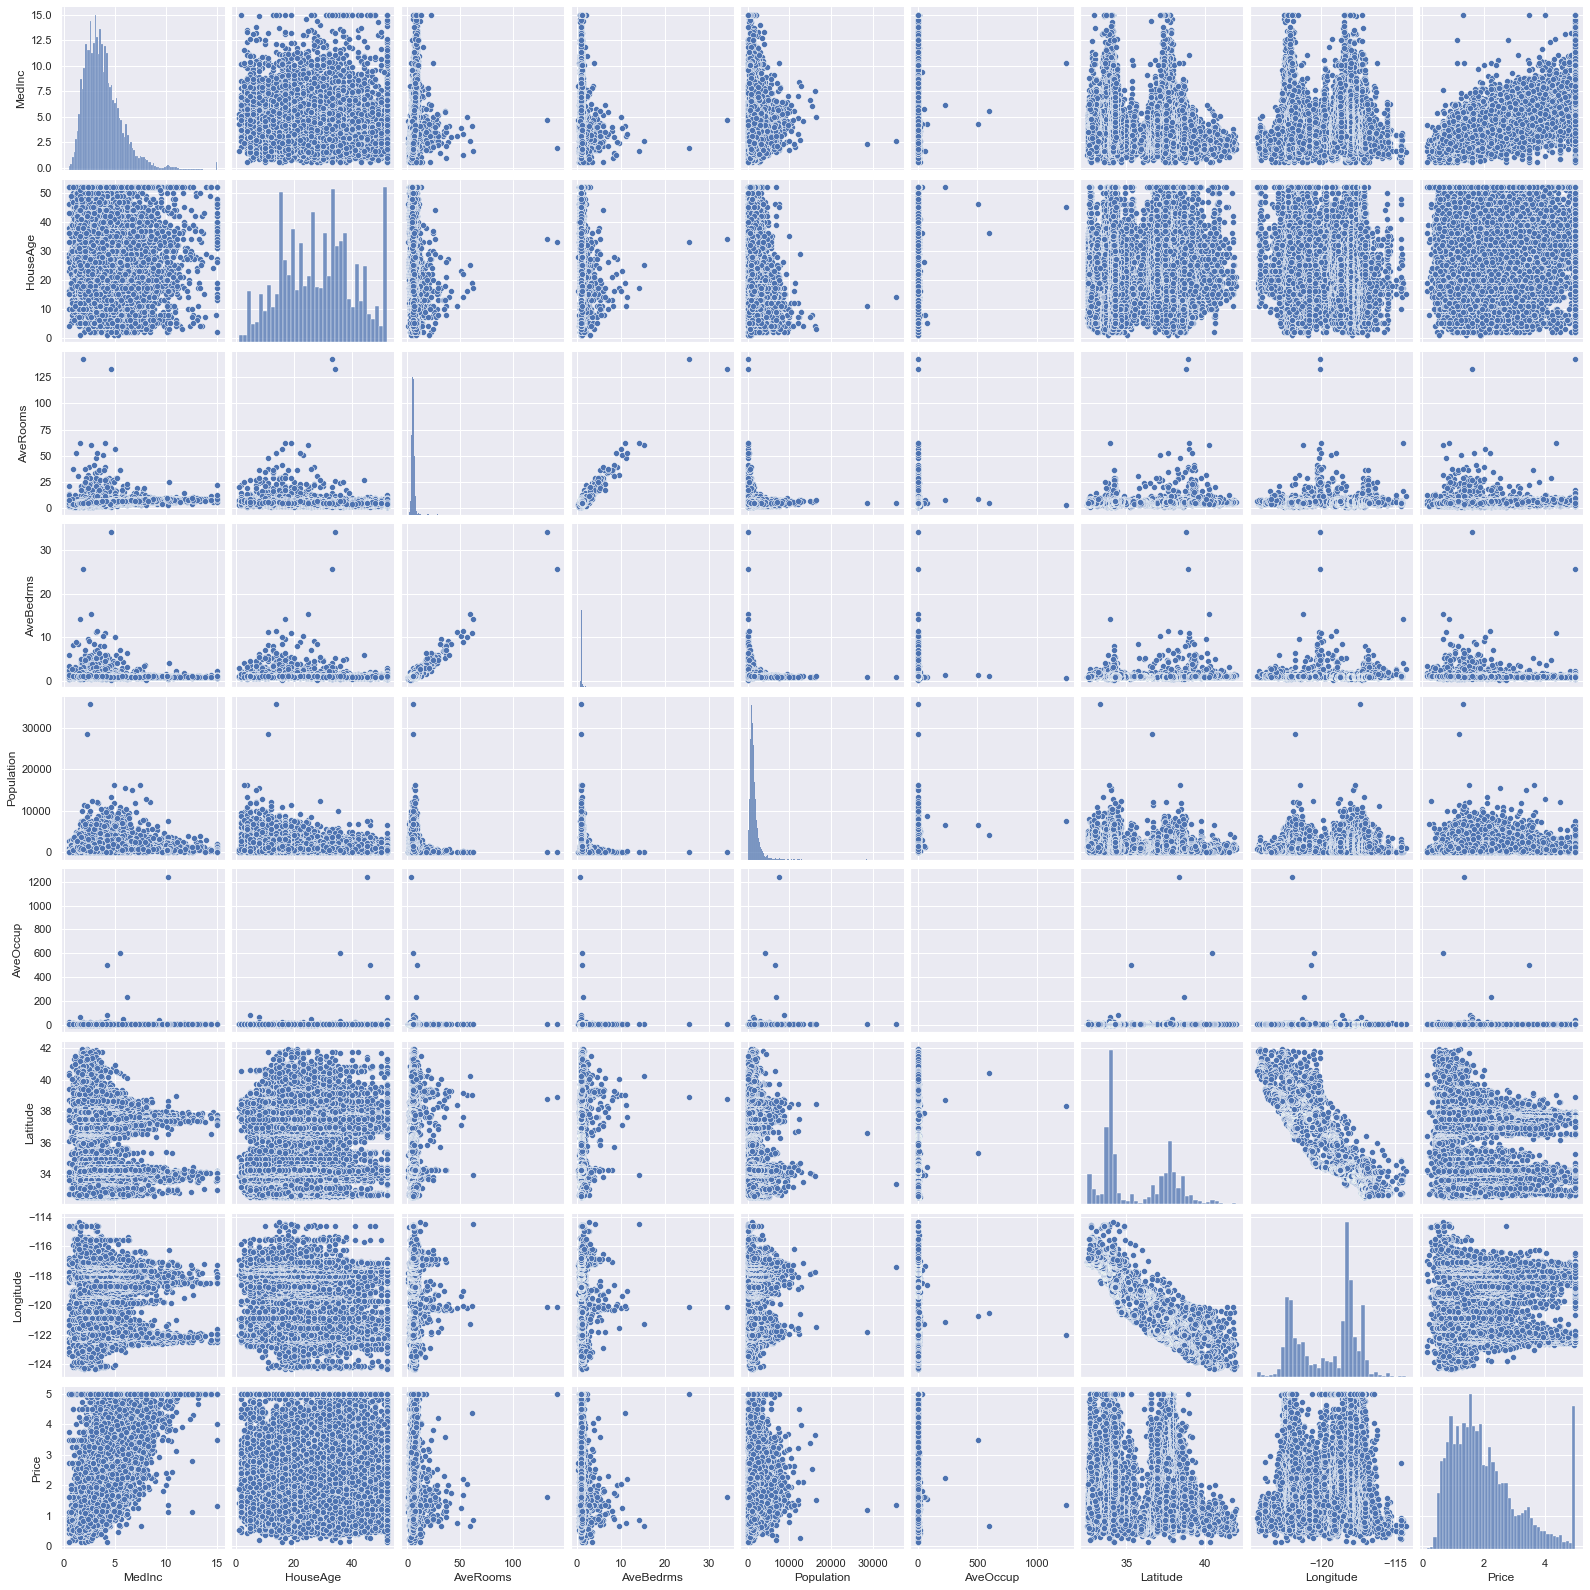

In [9]:
sns.pairplot(dataset)

#### Vérification de l'influence des caractéristiques sur le prix

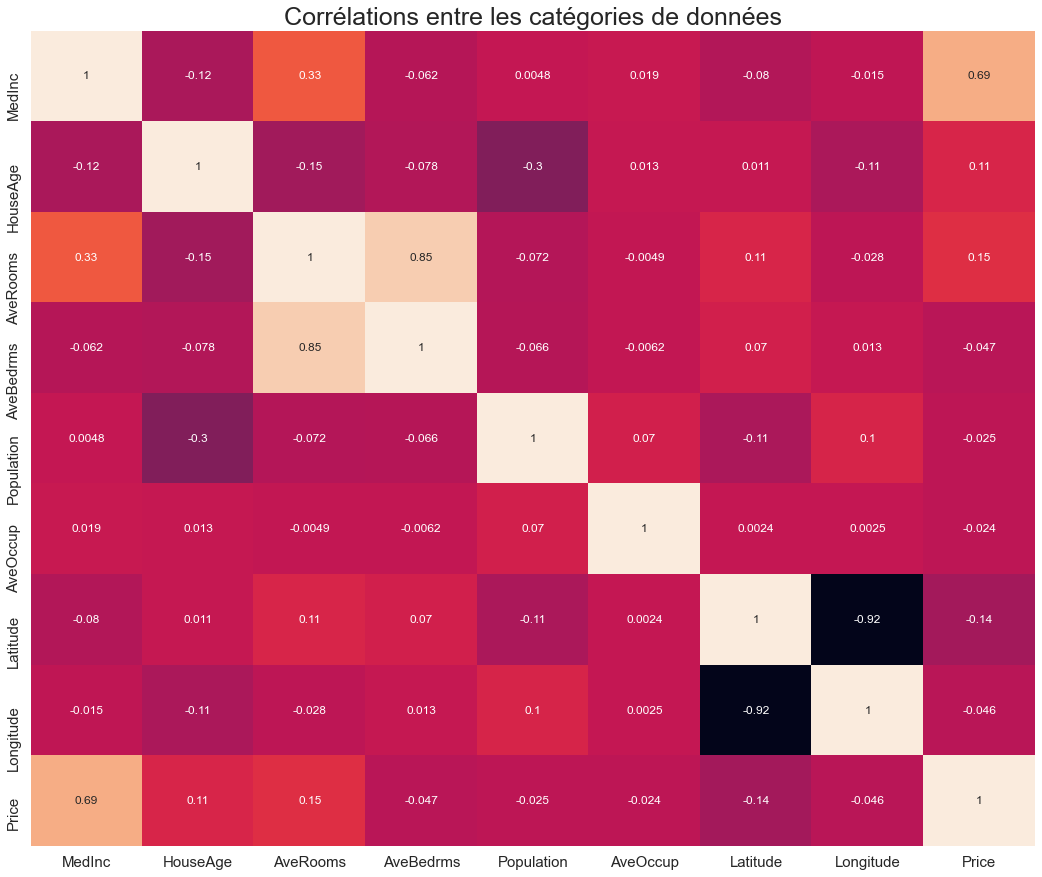

In [10]:
plt.figure(figsize=(18,15))        #définition de la taille totale du plot
sns.heatmap(dataset.corr(), annot=True, cbar=False)        #seaborn.type_de_plot(dataframe.correlation())
plt.title("Corrélations entre les catégories de données", fontsize=25)  #paramètres du titre affiché
plt.tick_params(labelsize=15)      #réglages graphiques de la barre à droite
plt.show()                         #montrer le plot

#### Il y a visiblement un lien entre le prix des biens et le revenu médian d'une zone

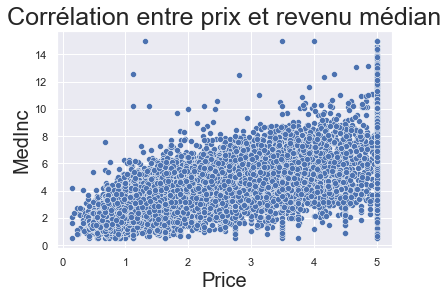

In [11]:
sns.scatterplot(x=dataset.Price,y=dataset.MedInc)
plt.title("Corrélation entre prix et revenu médian", fontsize=25)
plt.ylabel("MedInc", fontsize=20)
plt.xlabel("Price", fontsize=20)
plt.show()

## Vérification des outliers

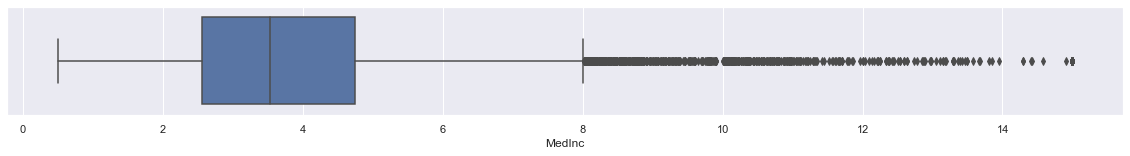

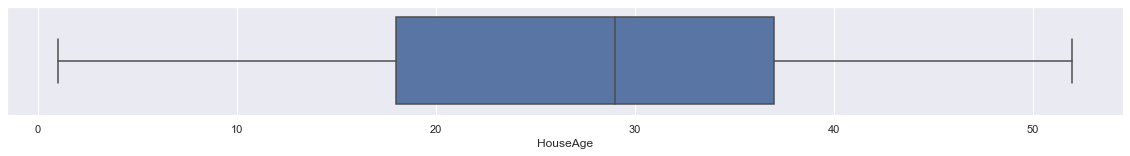

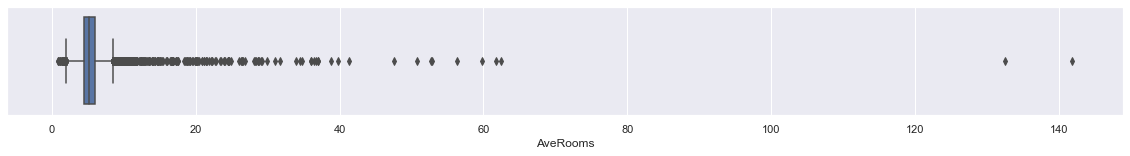

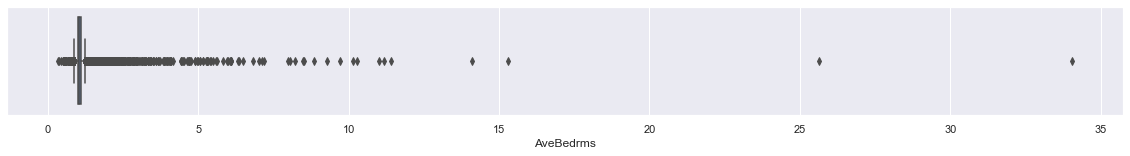

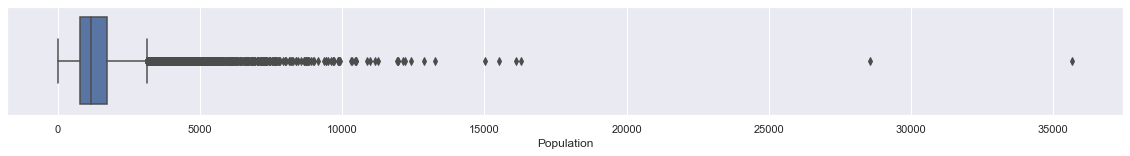

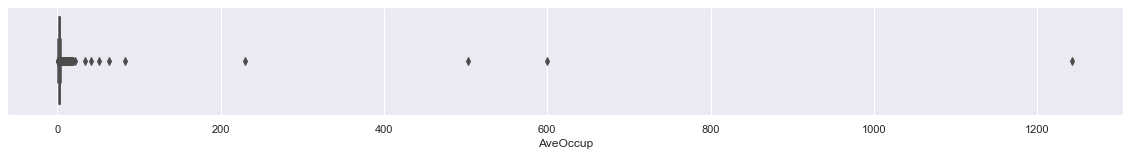

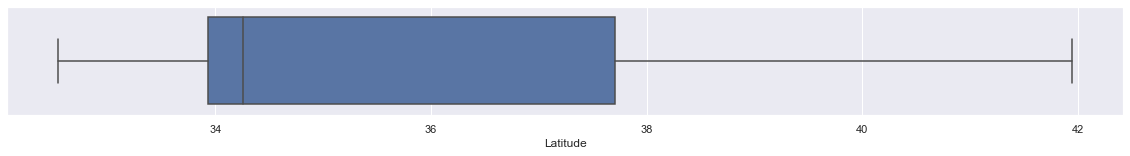

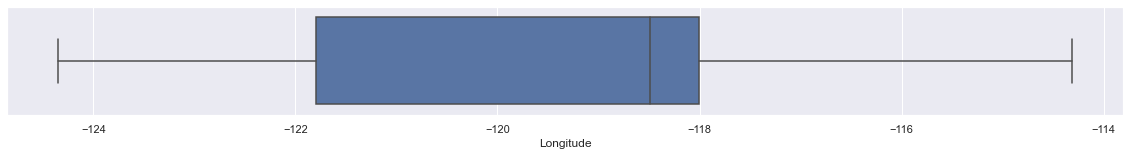

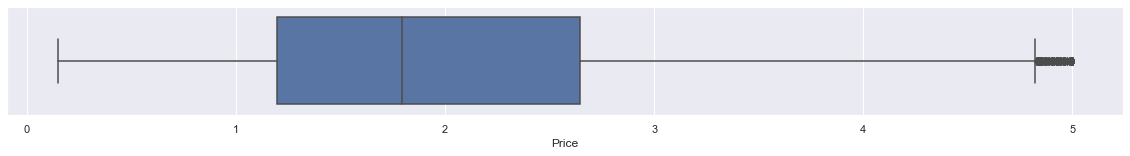

In [13]:
for col in dataset:
    plt.figure(figsize=(20,2))
    sns.boxplot(dataset[col])
    plt.show()

Population : beaucoup de données atypiques, qui correspondent aux grandes métropoles.
<br>MedInc : Californie = San Francisco = Silicon Valley et autres lieux de richesse.
<br>AveRooms : Los Angeles = Hollywood et autres berceaux à villas. Il y a peut-être quand même des données aberrantes.
<br>AveRooms : Idem AveRooms, jusqu'à 34 chambres semble logique
<br>AveOccup : Analyser les outliers

## A la recherche du meilleur modèle
### Sur données non standardisées

In [14]:
X = dataset.iloc[:, 0:-1]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.33,41.00,6.98,1.02,322.00,2.56,37.88,-122.23
1,8.30,21.00,6.24,0.97,2401.00,2.11,37.86,-122.22
2,7.26,52.00,8.29,1.07,496.00,2.80,37.85,-122.24
3,5.64,52.00,5.82,1.07,558.00,2.55,37.85,-122.25
4,3.85,52.00,6.28,1.08,565.00,2.18,37.85,-122.25


In [16]:
y = dataset["Price"]
y.head()

0   4.53
1   3.58
2   3.52
3   3.41
4   3.42
Name: Price, dtype: float64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LGBMRegressor                                0.84       0.84  0.46        0.26
HistGradientBoostingRegressor                0.83       0.83  0.46        1.42
XGBRegressor                                 0.83       0.83  0.46        0.98
ExtraTreesRegressor                          0.81       0.81  0.49        4.02
RandomForestRegressor                        0.81       0.81  0.50        9.50
GradientBoostingRegressor                    0.79       0.79  0.52        3.60
BaggingRegressor                             0.79       0.79  0.52        0.97
MLPRegressor                                 0.77       0.77  0.54       10.17
NuSVR                                        0.74       0.74  0.58       11.19
SVR                                          0.73       0.73  0.59        9.13
KNeighborsRegressor                          0.67   

### Sur données standardisées

In [21]:
k = StandardScaler().fit_transform(X)

df_train_stand = pd.DataFrame(k, columns = X.columns, index=dataset.index)

df_full_stand = df_train_stand.copy()
df_full_stand["Price"] = dataset["Price"]
df_full_stand.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,2.34,0.98,0.63,-0.15,-0.97,-0.05,1.05,-1.33,4.53
1,2.33,-0.61,0.33,-0.26,0.86,-0.09,1.04,-1.32,3.58
2,1.78,1.86,1.16,-0.05,-0.82,-0.03,1.04,-1.33,3.52
3,0.93,1.86,0.16,-0.05,-0.77,-0.05,1.04,-1.34,3.41
4,-0.01,1.86,0.34,-0.03,-0.76,-0.09,1.04,-1.34,3.42


In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_full_stand.iloc[:, 0:-1], df_full_stand["Price"],
                                                    train_size=0.8, random_state=12)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [03:37<00:00,  5.17s/it]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LGBMRegressor                                0.85       0.85  0.45        0.31
HistGradientBoostingRegressor                0.85       0.85  0.46        1.35
XGBRegressor                                 0.84       0.84  0.47        1.04
ExtraTreesRegressor                          0.82       0.82  0.49        4.13
RandomForestRegressor                        0.82       0.82  0.50        9.89
GradientBoostingRegressor                    0.80       0.80  0.53        3.18
MLPRegressor                                 0.79       0.80  0.53       20.81
BaggingRegressor                             0.79       0.79  0.53        0.98
NuSVR                                        0.75       0.75  0.59       12.05
SVR                                          0.74       0.74  0.59        9.34
KNeighborsRegressor                          0.70   

Légère amélioration, rien de bien fou.
### Sur données standardisées, outliers supprimés

MedInc > 8
<br>AveRooms > 40
<br>AveOccup > 200

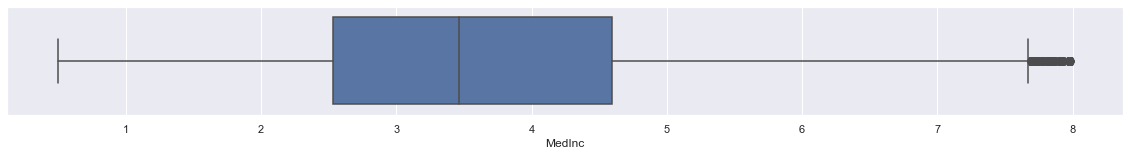

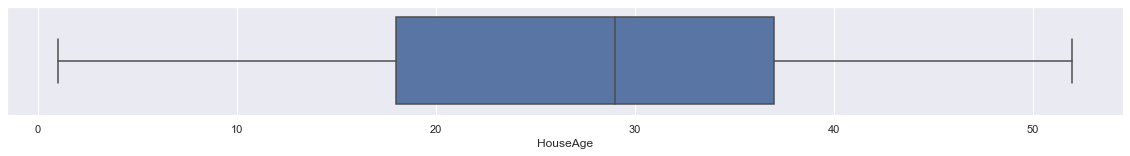

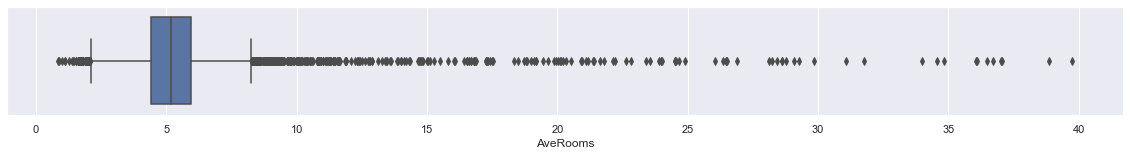

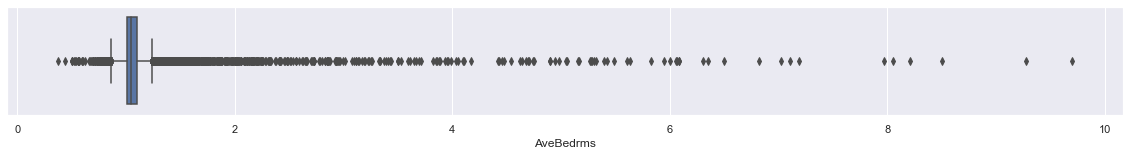

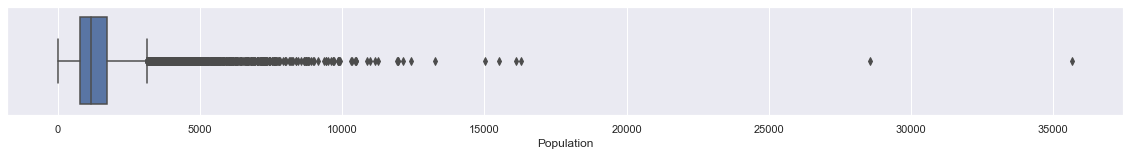

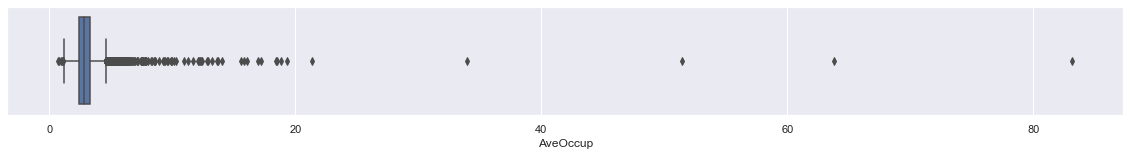

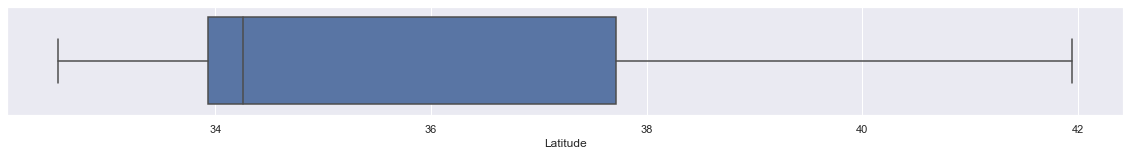

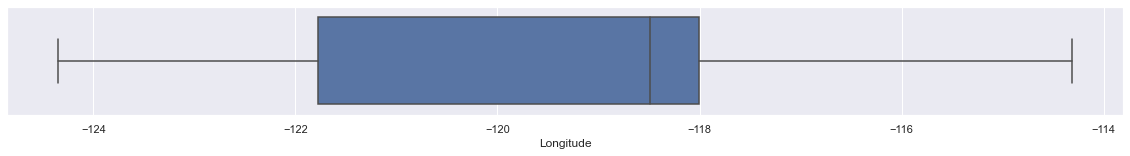

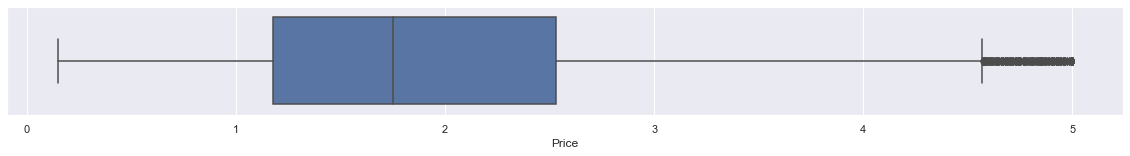

In [42]:
df = dataset.copy()
df = df[df["MedInc"] < 8]
df = df[df["AveRooms"] < 40]
df = df[df["AveOccup"] < 200]

for col in df:
    plt.figure(figsize=(20,2))
    sns.boxplot(df[col])
    plt.show()

In [28]:
X = df.iloc[:, 0:-1]

df_train_stand = pd.DataFrame(k, columns = X.columns, index=dataset.index)

df_full_stand = df_train_stand.copy()
df_full_stand["Price"] = dataset["Price"]

X_train, X_test, y_train, y_test = train_test_split(df_full_stand.iloc[:, 0:-1], df_full_stand["Price"],
                                                    train_size=0.8, random_state=12)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [03:18<00:00,  4.74s/it]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LGBMRegressor                                0.85       0.85  0.45        0.25
HistGradientBoostingRegressor                0.85       0.85  0.46        1.26
XGBRegressor                                 0.84       0.84  0.47        0.97
ExtraTreesRegressor                          0.82       0.82  0.49        3.97
RandomForestRegressor                        0.82       0.82  0.50        9.81
GradientBoostingRegressor                    0.80       0.80  0.53        3.67
MLPRegressor                                 0.79       0.80  0.53       19.61
BaggingRegressor                             0.79       0.79  0.53        0.96
NuSVR                                        0.75       0.75  0.59       11.50
SVR                                          0.74       0.74  0.59        8.65
KNeighborsRegressor                          0.70   

Seul du temps de traitement a été gagné.
# Modélisation & évaluation

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df_full_stand.iloc[:, 0:-1], df_full_stand["Price"],
                                                    train_size=0.8, random_state=12)

reg = LGBMRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('r2 score: %.2f'% r2_score(y_test, y_pred))
print('Mean squared error: %.2f'% mean_squared_error(y_test, y_pred))
print("Mean absolute error: %2f"% mean_absolute_error(y_test,y_pred))
print("explained_variance_score: %2f"% explained_variance_score(y_test,y_pred))
print("max_error: %2f"% max_error(y_test,y_pred))
print("median_absolute_error: %2f"% median_absolute_error(y_test,y_pred))

r2 score: 0.85
Mean squared error: 0.21
Mean absolute error: 0.307053
explained_variance_score: 0.849948
max_error: 2.918296
median_absolute_error: 0.205399


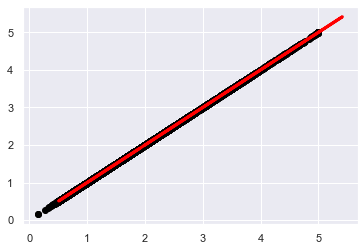

In [45]:
# Plot des résultats
plt.scatter(y_test, y_test, color='black') #données réelles
plt.plot(y_pred, y_pred, color='red', linewidth=3); #données prédites

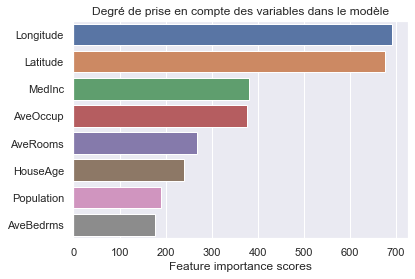

In [46]:
#plot des scores d'importance
feature_imp = pd.Series(reg.feature_importances_, index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel("Feature importance scores")
plt.title("Degré de prise en compte des variables dans le modèle")
plt.show()

In [47]:
import pickle

pickle.dump(reg, open('model.pkl','wb'))

In [48]:
# Chargement du modèle pour tester
model = pickle.load(open('model.pkl','rb'))
print(model.predict([[2.34,0.98,0.63,-0.15,-0.97,-0.05,1.05,-1.33]]))

[4.11106085]


In [50]:
print(model.predict([[1.78,1.86,1.16,-0.05,-0.82,-0.03,1.04,-1.33]]))

[4.18394476]


In [52]:
dataset.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'Price'],
      dtype='object')